In [12]:
import pandas as pd
import os.path as op
import nibabel as nb
import numpy as np
import json
import trimesh
import open3d as o3d
import matplotlib.pylab as plt
from matplotlib import cm, colors
from utilities import files
import tqdm.auto as tqdm
from copy import copy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, minmax_scale
from sklearn.manifold import MDS
from scipy.spatial.distance import euclidean
from tools import smooth_csd, compute_csd

In [2]:
def data_to_rgb(data, n_bins, cmap, vmin, vmax, vcenter=0, ret_map=False, norm="TS"):
    if norm == "TS":
        divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    elif norm == "N":
        divnorm = colors.Normalize(vmin=vmin, vmax=vmax)
    elif norm == "LOG":
        divnorm = colors.LogNorm(vmin=vmin, vmax=vmax)
    c = cm.ScalarMappable(divnorm, cmap=cmap)
    bins = np.histogram_bin_edges(data, bins=n_bins)
    bin_ranges = list(zip(bins[:-1], bins[1:]))
    colour_mapped = np.zeros((data.shape[0], 4))
    for br_ix, br in enumerate(bin_ranges):
        map_c = (data >= br[0]) & (data <= br[1])
        colour_mapped[map_c,:] = c.to_rgba(bins[1:][br_ix])
    
    if not ret_map:
        return colour_mapped
    elif ret_map:
        return colour_mapped, c


def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()


In [3]:
info_path = "/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/info.json"
with open(info_path, "r") as fp:
    info = json.load(fp)

atlas = pd.read_csv(info["atlas"])
atlas_labels = np.load(info["atlas_colors_path"])

csd_files = files.get_files(
    op.join(info["subject_path"], "inverted"),
    "time_CSD", "npy"
)[2]

In [4]:
times = {
    "visual": np.linspace(-0.2, 0.8, num=601),
    "motor": np.linspace(-0.5, 0.5, num=601)
}

In [5]:
ROI_labels = ["L_V1_ROI", "L_MT_ROI", "R_V1_ROI", "R_MT_ROI"]
total_ix = np.arange(atlas_labels.shape[0])
ROI_vertices = {i: total_ix[[i == al.decode("utf=8") for al in atlas_labels]] for i in ROI_labels}
csd_file = csd_files[1]
epoch_type = csd_file.split("/")[-1].split("-")[-2]

In [6]:
csd_data = np.load(csd_files[1])
true_CSD = {}
for l in ROI_labels:
    true_CSD[l] = []
    for rv in ROI_vertices[l]:
        true_CSD[l].append(csd_data[rv, :, :])
true_CSD = {i: np.array(true_CSD[i]) for i in ROI_labels} # vertex x layer x time

In [7]:
pca_time_sel = np.where((times[epoch_type] >= 0) & (times[epoch_type] <= 0.2))[0]
pca_csd_dataset = {i: true_CSD[i][:,:, pca_time_sel].reshape(true_CSD[i].shape[0], -1) for i in ROI_labels}

/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/numpy/core/_methods.py:212: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/mszul/miniconda3/envs/mne/lib/python3.9/site-packages/numpy/core/_methods.py:212: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


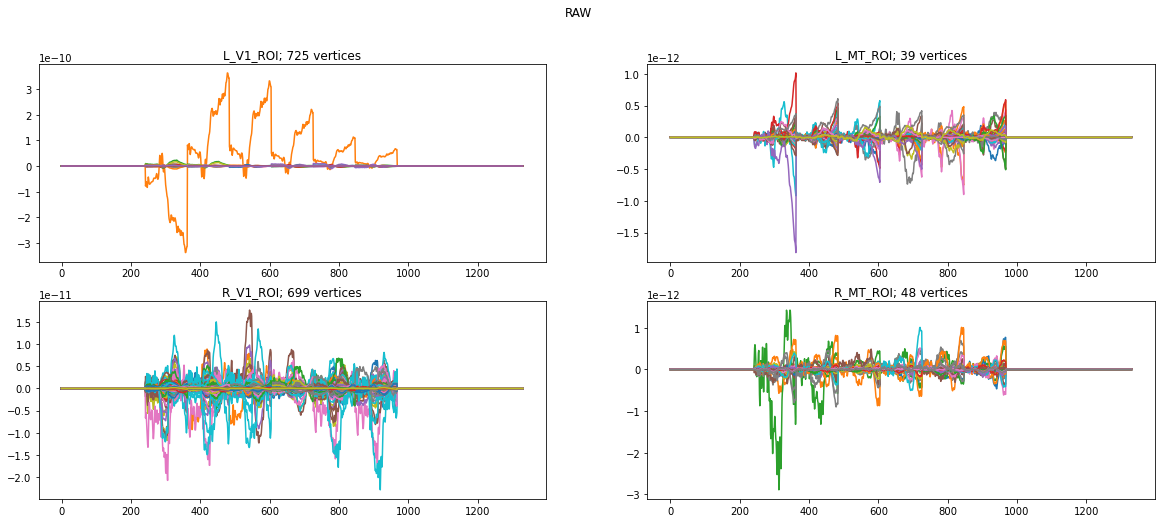

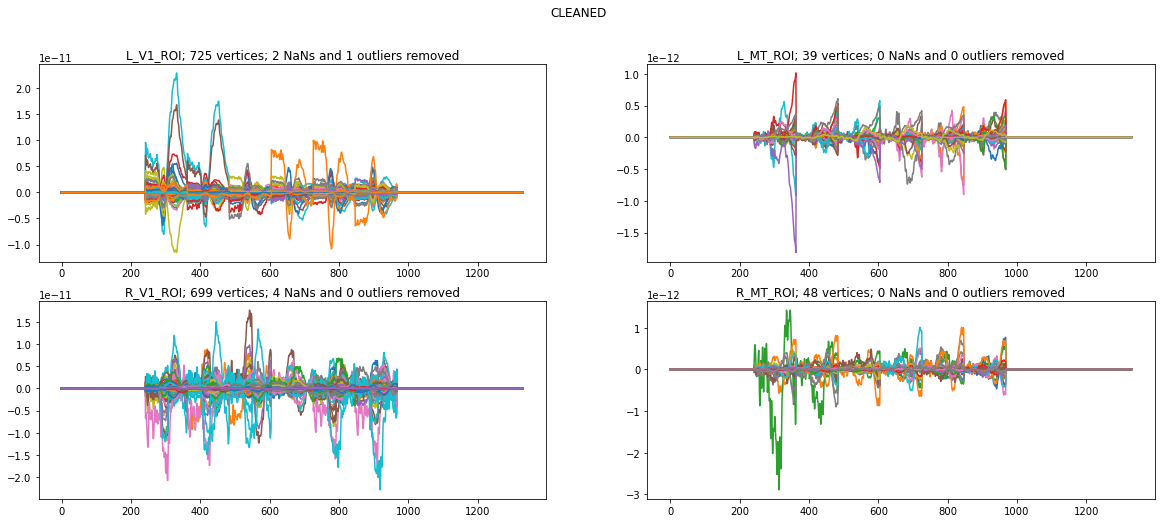

In [8]:
rows = int(len(ROI_labels)/2)
f, ax = plt.subplots(rows, 2, figsize=(20, 4*rows))
f.suptitle("RAW")
ax = ax.flatten()
for roi_ix, roi in enumerate(ROI_labels):
    ax[roi_ix].set_title("{}; {} vertices".format(roi, ROI_vertices[roi].shape[0]))
    ax[roi_ix].plot(pca_csd_dataset[roi].T)


f, ax = plt.subplots(rows, 2, figsize=(20, 4*rows))
f.suptitle("CLEANED")
ax = ax.flatten()
ROI_outlier_map = {}
for roi_ix, roi in enumerate(ROI_labels):
    metric = pca_csd_dataset[roi].std(axis=1)
    nan_map = np.isnan(metric)
    minmax = np.percentile(metric[~nan_map], 0.005), np.percentile(metric[~nan_map], 99.995)
    outlier_map = metric > minmax[1] + minmax[1] * 0.01
    unwanted_map = nan_map | outlier_map
    ax[roi_ix].set_title("{}; {} vertices; {} NaNs and {} outliers removed".format(roi, ROI_vertices[roi].shape[0], sum(nan_map), sum(outlier_map)))
    ax[roi_ix].plot(pca_csd_dataset[roi][~unwanted_map].T)
    ROI_outlier_map[roi] = unwanted_map

In [9]:
PCA_results = {}
for roi_ix, roi in enumerate(ROI_labels):
    ds = pca_csd_dataset[roi][~ROI_outlier_map[roi]]
    scaler = RobustScaler()
    ds = scaler.fit_transform(ds)
    pca = PCA(n_components=30)
    ds_pca = pca.fit_transform(ds)
    
    PCA_results[roi] = [ds_pca, pca.components_, pca.explained_variance_ratio_]

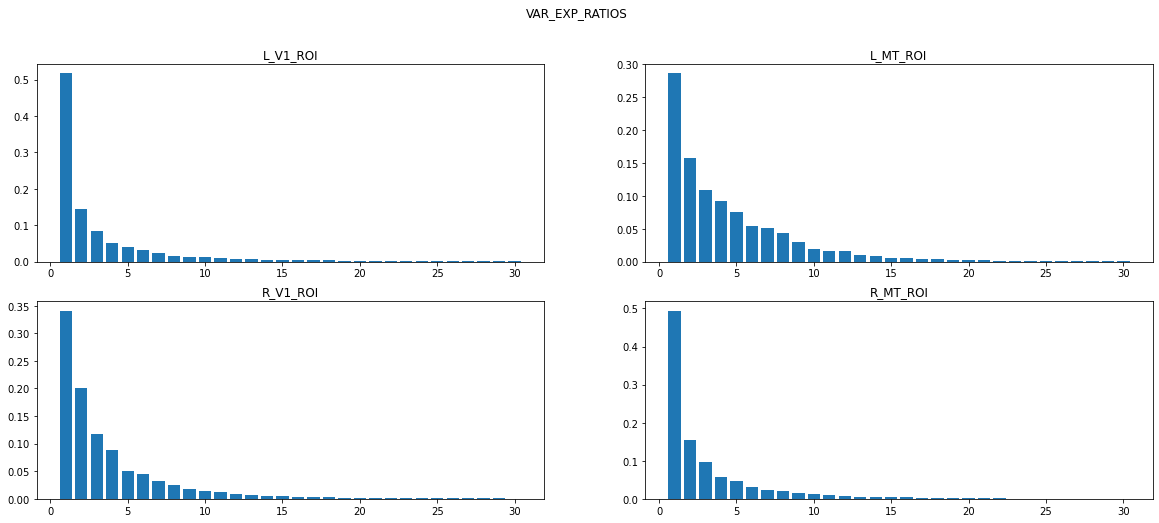

In [10]:
rows = int(len(ROI_labels)/2)
f, ax = plt.subplots(rows, 2, figsize=(20, 4*rows), facecolor="white")
f.suptitle("VAR_EXP_RATIOS")
ax = ax.flatten()
for roi_ix, roi in enumerate(ROI_labels):
    ax[roi_ix].bar(np.arange(1, PCA_results[roi][2].shape[0]+1), PCA_results[roi][2]);
    ax[roi_ix].set_title(roi)
plt.savefig("/home/mszul/git/DANC_multilayer_laminar/output/PCA_ROI_VAR_EXP.png", dpi=300)

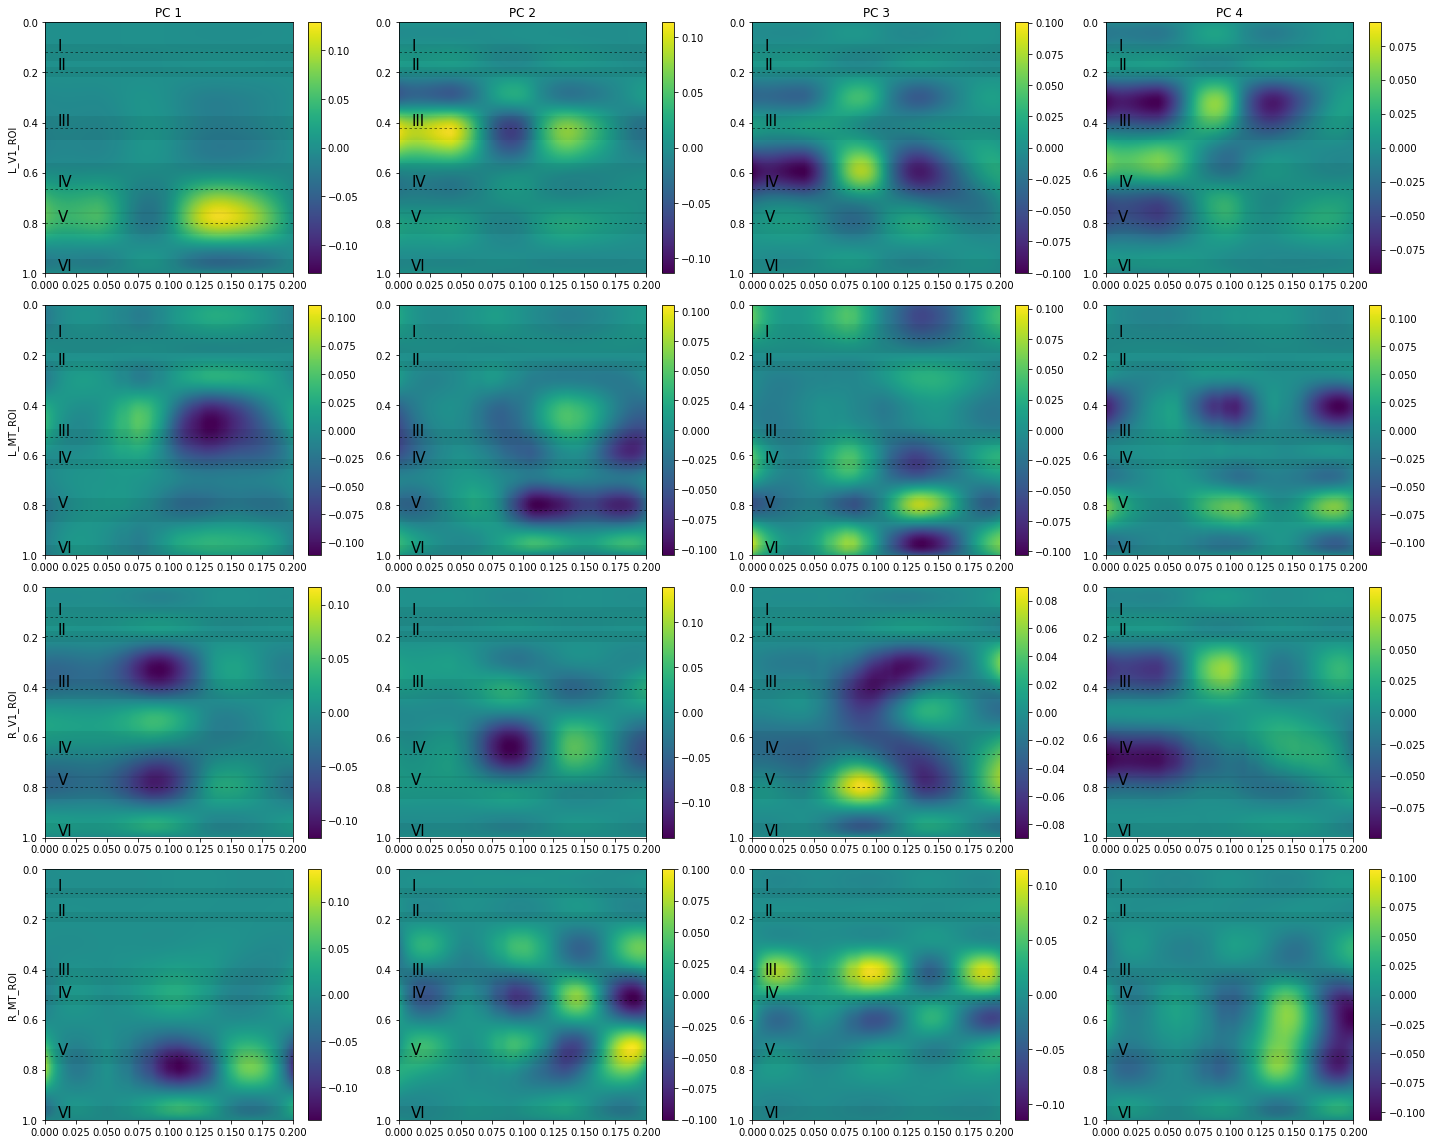

In [13]:
rows = len(ROI_labels)
f, ax = plt.subplots(rows, 4, figsize=(20, 4*rows), facecolor="white")
for row, roi in enumerate(ROI_labels):
    ax[row, 0].set_ylabel(roi)
    for column in range(4):
        ax[0, column].set_title("PC {}".format(column+1))
        eigenvector_csd = smooth_csd(np.array(np.split(PCA_results[roi][1][column], info["n_surf"])), info["n_surf"])
        plot_csd(
            eigenvector_csd, ROI_vertices[roi], info["big_brain_layers_path"], 
            times["visual"][pca_time_sel], ax[row, column], cmap="viridis"
        )
plt.tight_layout()
plt.savefig("/home/mszul/git/DANC_multilayer_laminar/output/PCA_EIGENVECTOR_CSD.png", dpi=300)

In [14]:
pca_scores = [PCA_results[i][0] for i in ROI_labels]

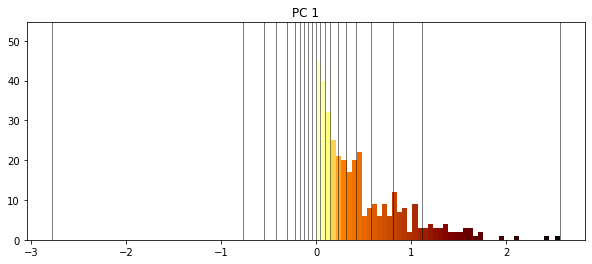

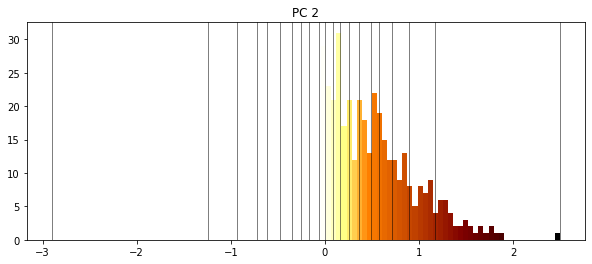

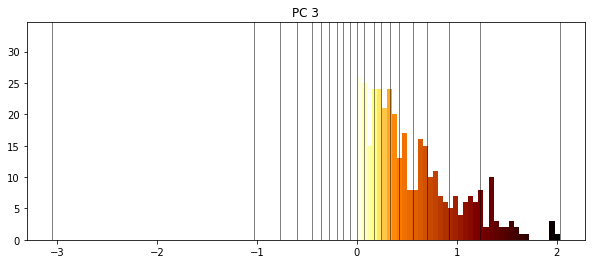

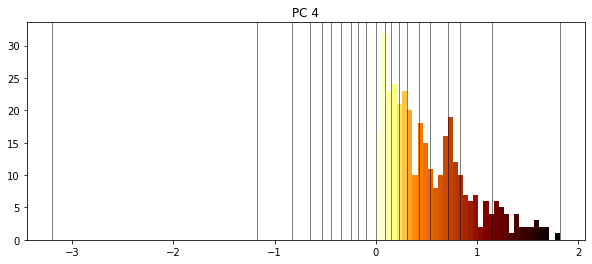

In [15]:
for i in range(4):
    f, ax = plt.subplots(1, 1, figsize=(10, 4))
    sc_log = np.log10(np.abs(pca_scores[0][:,i]))
    sc_log = sc_log - np.median(sc_log)
    n_bins = 100
    datacolors, mappable = data_to_rgb(
        sc_log, n_bins, "afmhot_r", np.percentile(sc_log, 50), 
        np.percentile(sc_log, 100), vcenter=np.percentile(sc_log, 75), ret_map=True
    )
    hist, bins, barlist = ax.hist(sc_log, bins=n_bins)
    for ix, xx in enumerate(barlist):
        plt.setp(xx, "facecolor", mappable.to_rgba(bins[ix+1]))

    for h in np.linspace(0, 100, num=21):
        ax.axvline(np.percentile(sc_log, h), lw=0.5, c="black")
    ax.set_title("PC {}".format(i+1))

In [208]:
SMOOTH_CSD = {}
for l in ROI_labels:
    SMOOTH_CSD[l] = []
    for rv in ROI_vertices[l]:
        SMOOTH_CSD[l].append(smooth_csd(csd_data[rv, :, :], info["n_surf"]))
        
for l in ROI_labels:
    SMOOTH_CSD[l] = np.array(SMOOTH_CSD[l])[~ROI_outlier_map[l]]

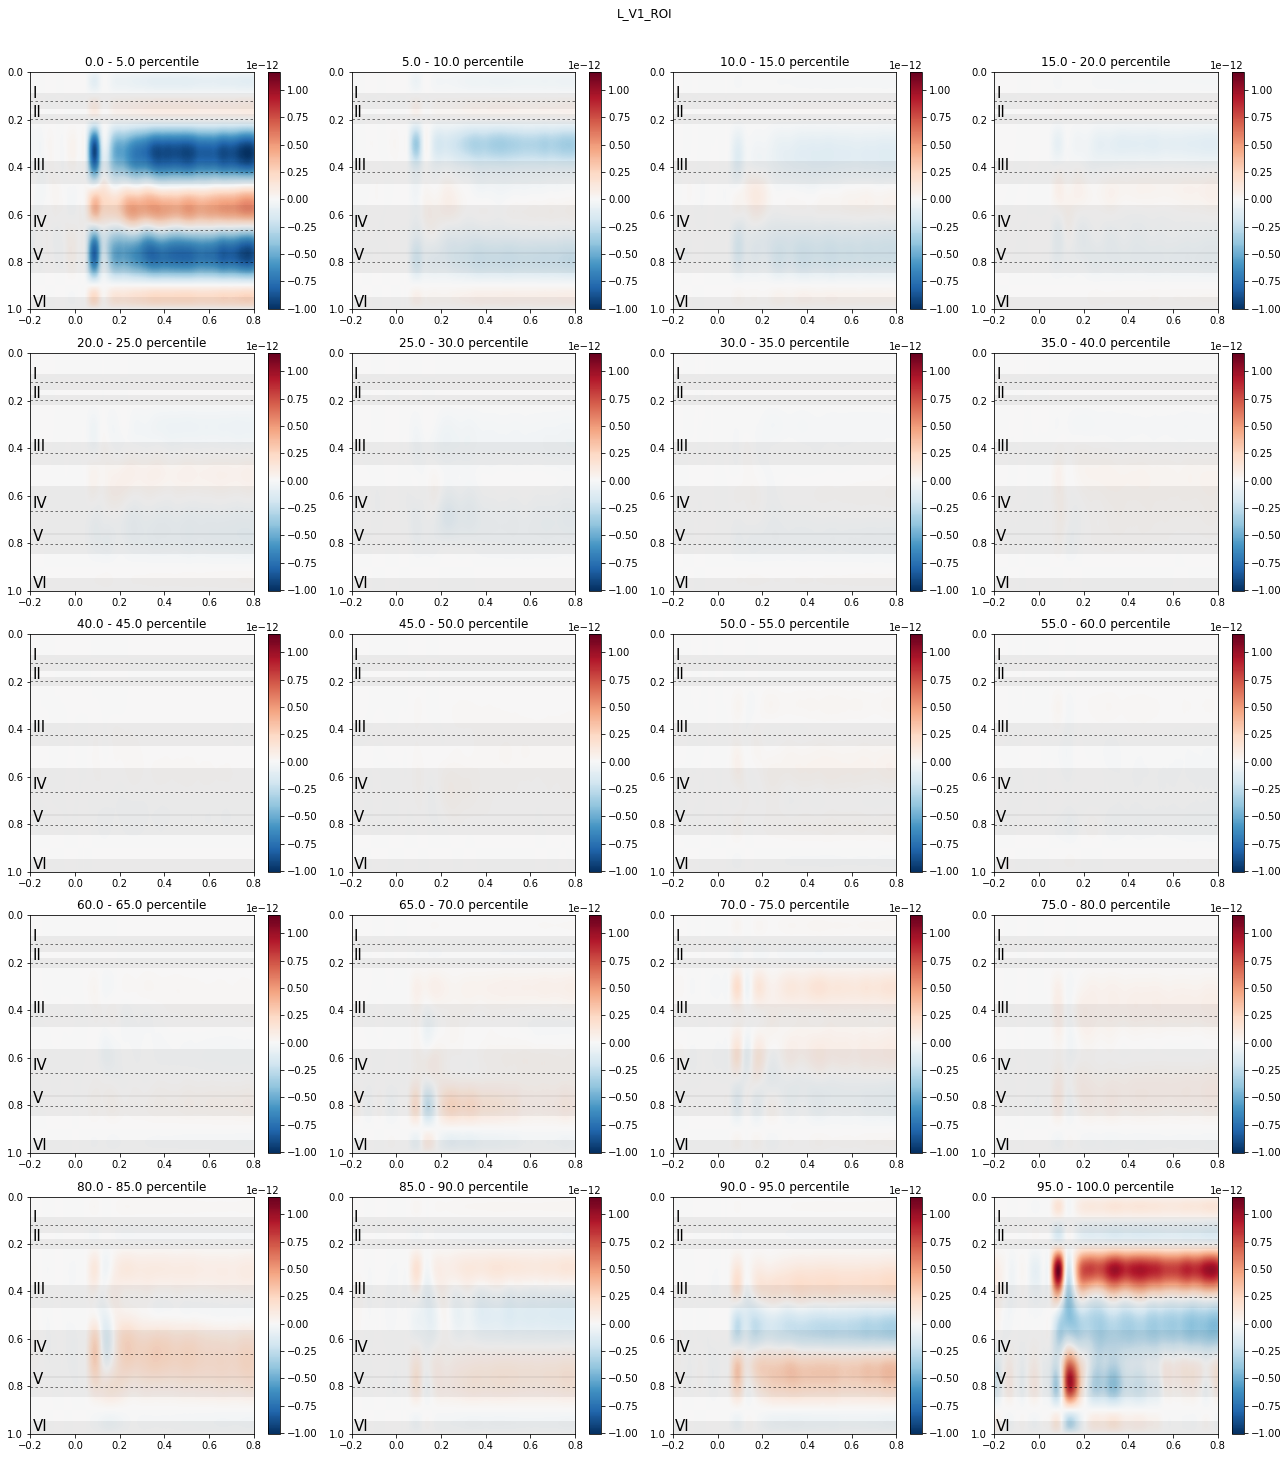

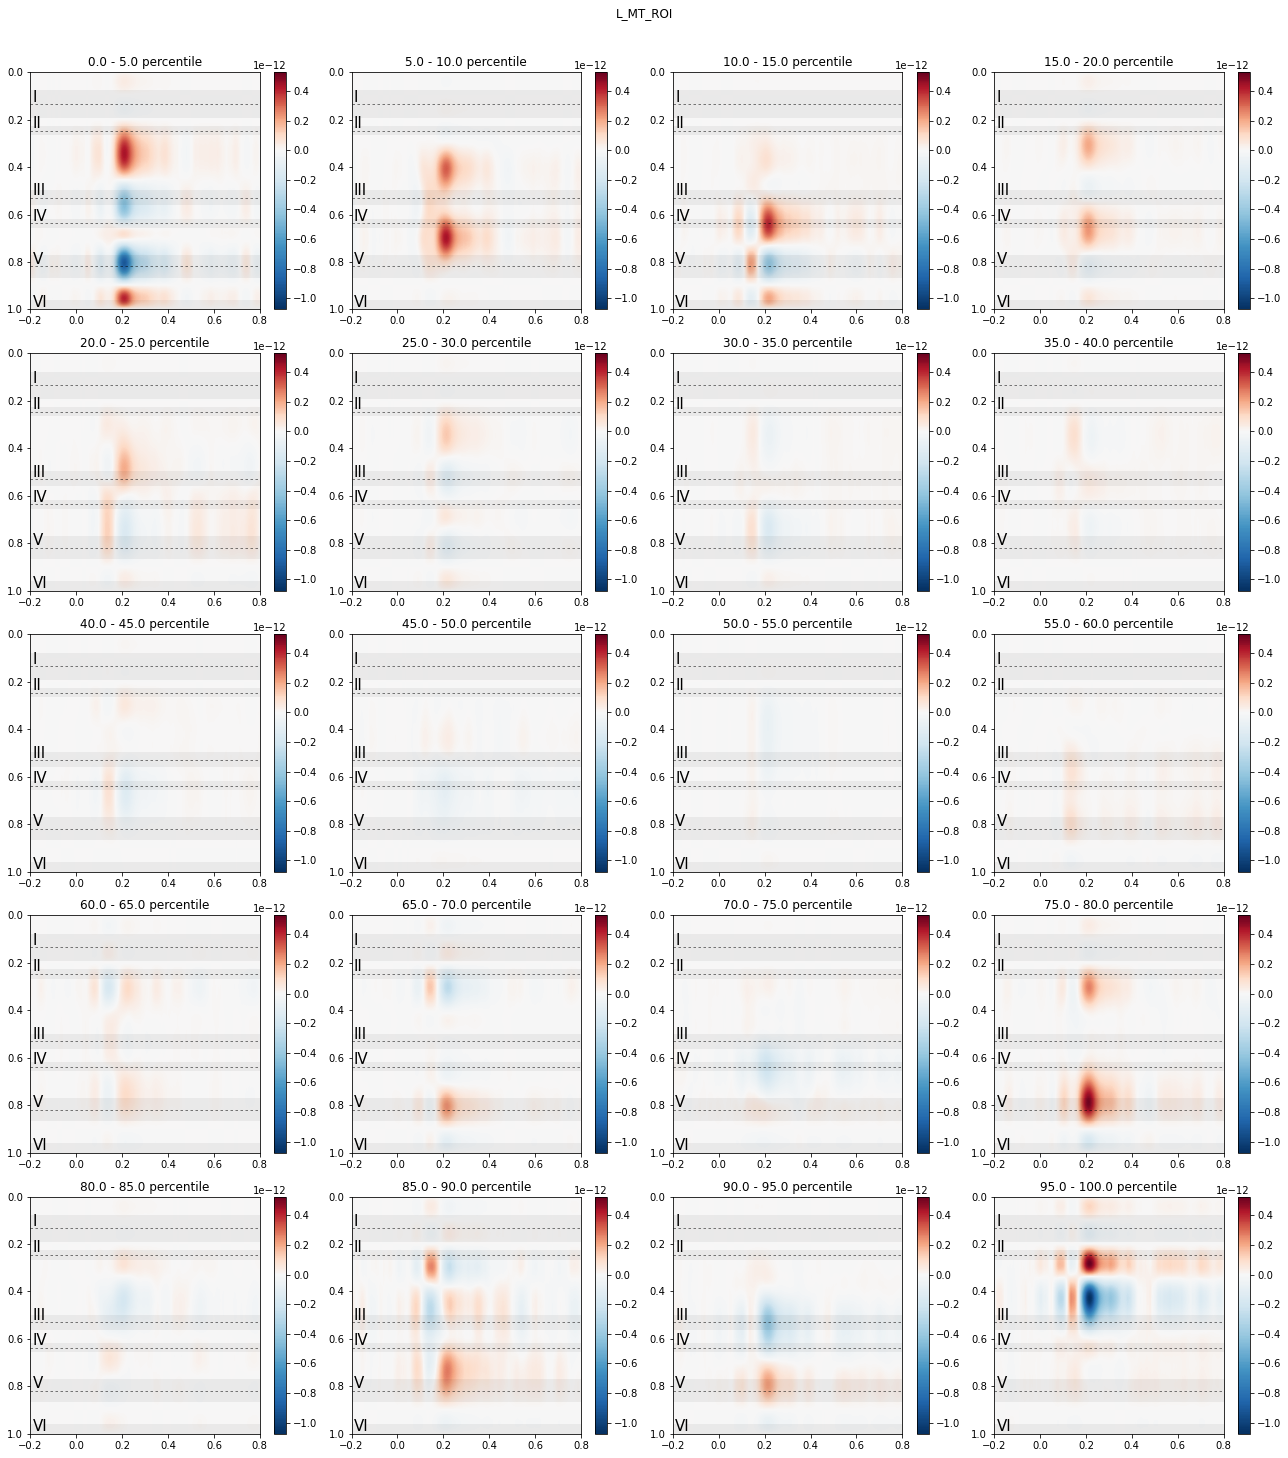

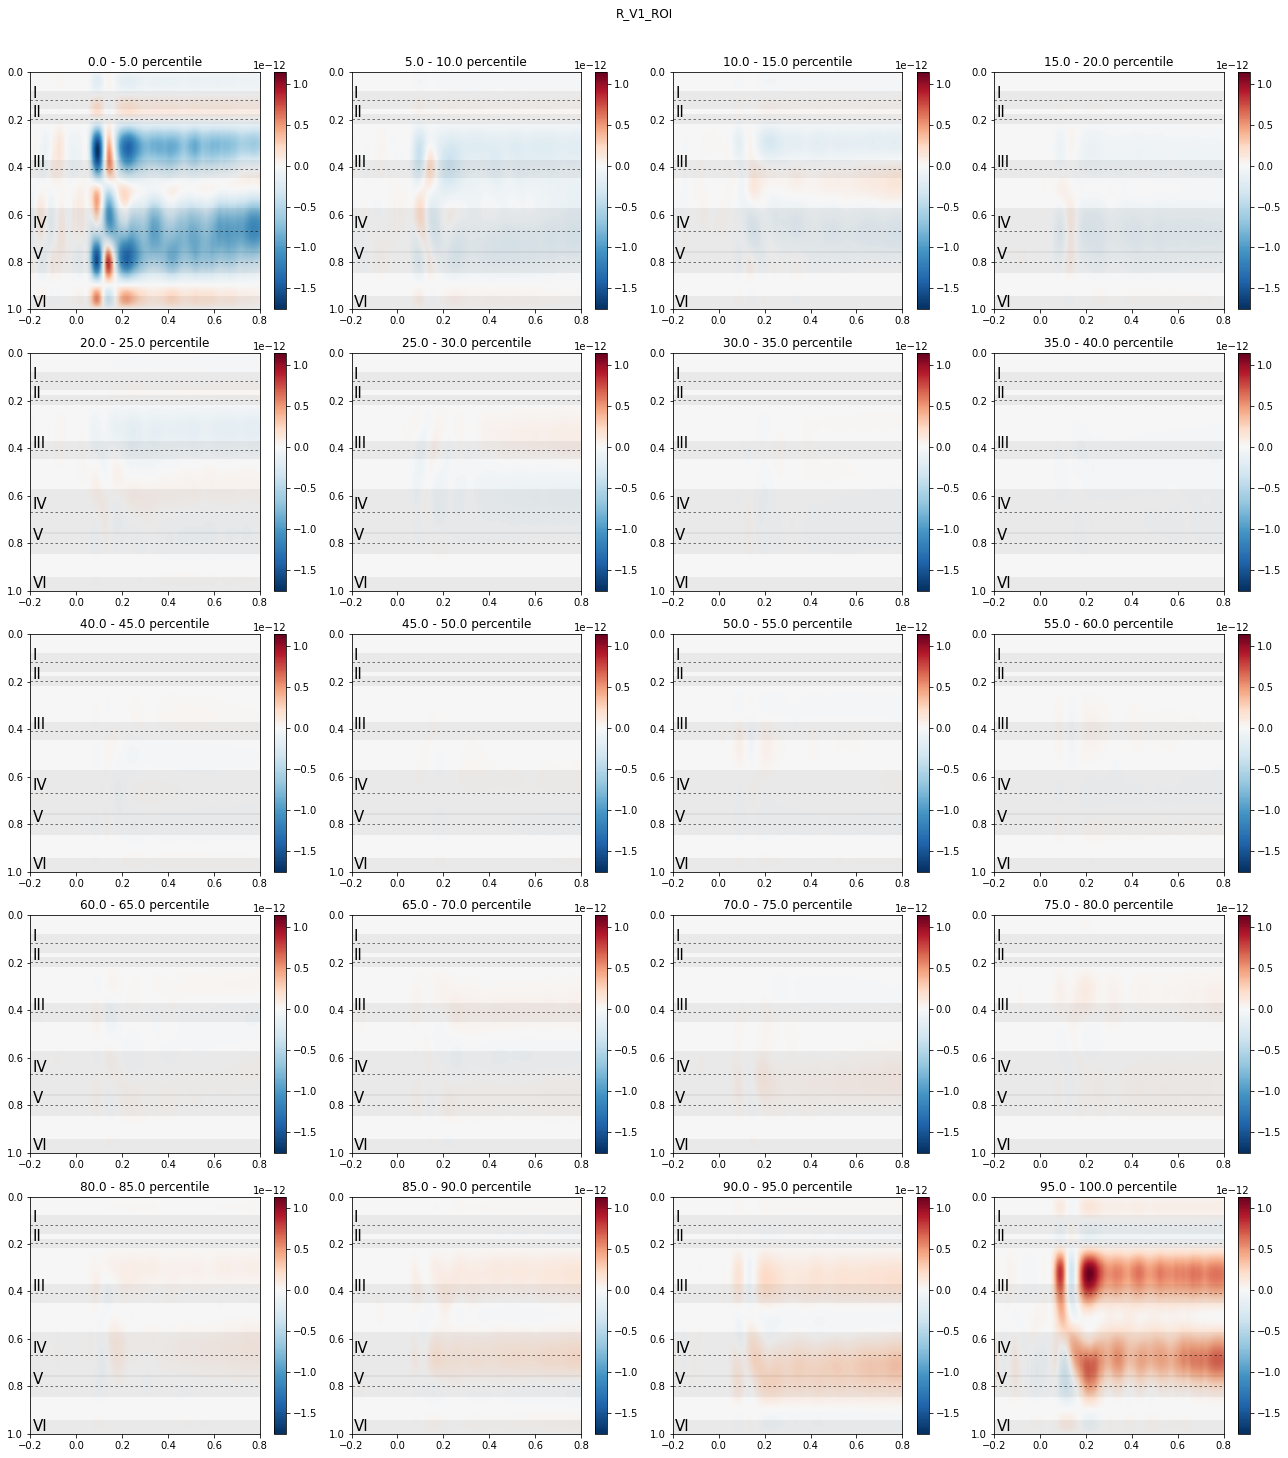

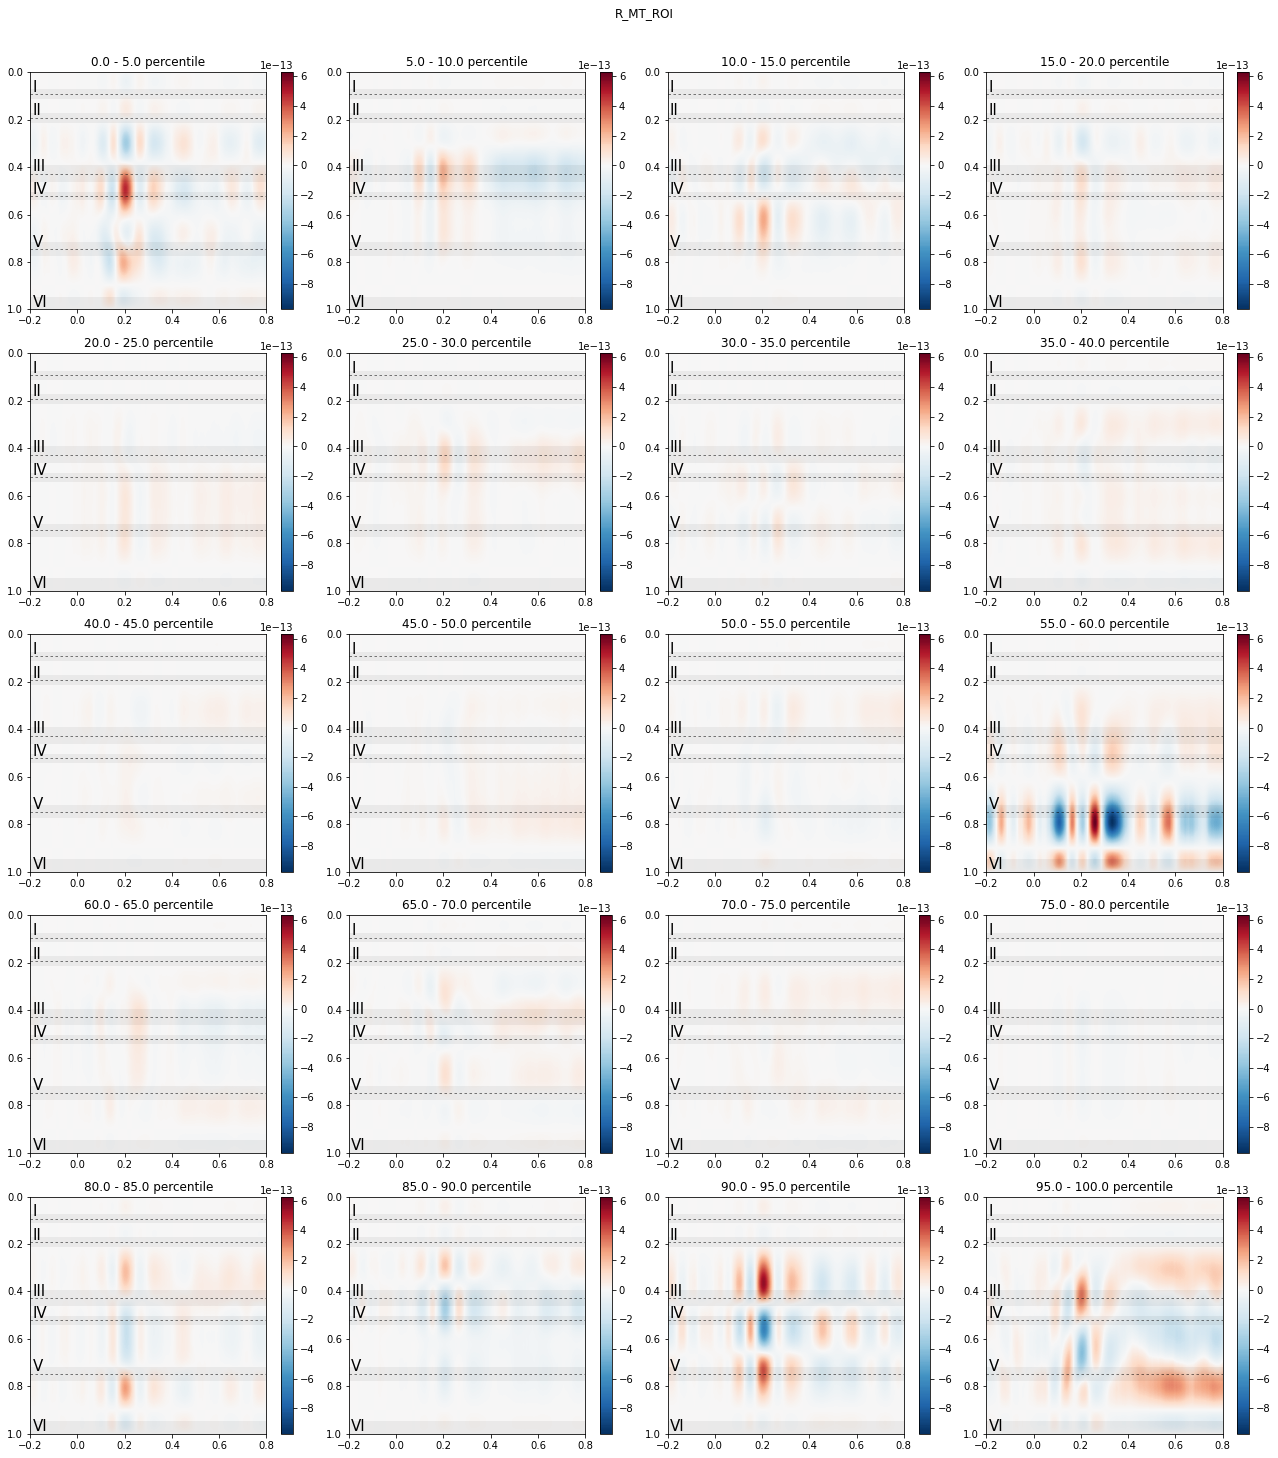

In [251]:
pc_comp = 3
n_bins = 100
PRC_ROI_CSD = {}
COLOR_MAP_ROI = {}
SC_LOG_ROI = {}
for l in ROI_labels:
    prc = np.linspace(0, 100, num=21)
    prc_bounds = list(zip(prc[:-1], prc[1:]))
    csd_bounds = []
    sc_log = np.log10(np.abs(PCA_results[l][0][:, pc_comp]))
    sc_log = sc_log - np.median(sc_log)
    SC_LOG_ROI[l] = sc_log
    sc_log = PCA_results[l][0][:, pc_comp]
    for ix, pb in enumerate(prc_bounds):
        bounds = [np.percentile(sc_log, i) for i in pb]
        pr_mask = np.where((sc_log >= bounds[0]) & (sc_log < bounds[1]))[0]
        mean_smooth_csd = np.mean(SMOOTH_CSD[l][pr_mask], axis=0)
        baseline = np.mean(mean_smooth_csd[:, np.where(times["visual"] < -0.01)], axis=2)
        csd_bounds.append(mean_smooth_csd - baseline)
    csd_bounds = np.array(csd_bounds)
    PRC_ROI_CSD[l] = csd_bounds
    COLOR_MAP_ROI[l] = data_to_rgb(
        sc_log, n_bins, "afmhot_r", np.percentile(sc_log, 50), 
        np.percentile(sc_log, 100), vcenter=np.percentile(sc_log, 75)
    )

for l in ROI_labels:
    v_mm = [PRC_ROI_CSD[l].min(), PRC_ROI_CSD[l].max()]
    f, ax = plt.subplots(5,4, figsize=(18, 20), facecolor="white")
    ax = ax.flatten()
    for ix, pb in enumerate(prc_bounds):
        ax[ix].set_title("{} - {} percentile".format(*pb))
        plot_csd(
            PRC_ROI_CSD[l][ix], ROI_vertices[l], info["big_brain_layers_path"],
            times["visual"], ax[ix], vmin_vmax=v_mm
        )
    f.suptitle(l, y=1.01)
    plt.tight_layout()
    plt.savefig("/home/mszul/git/DANC_multilayer_laminar/output/PC_{}_{}_CSD_mean_baseline.png".format(str(pc_comp+1).zfill(2), l), dpi=300)

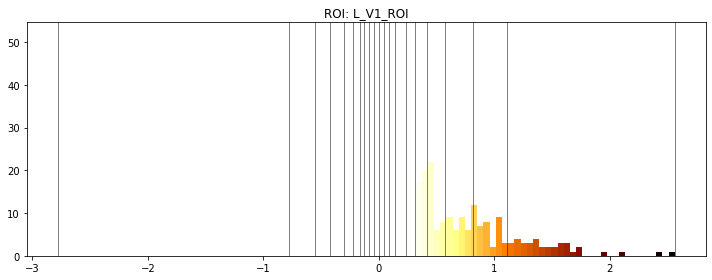

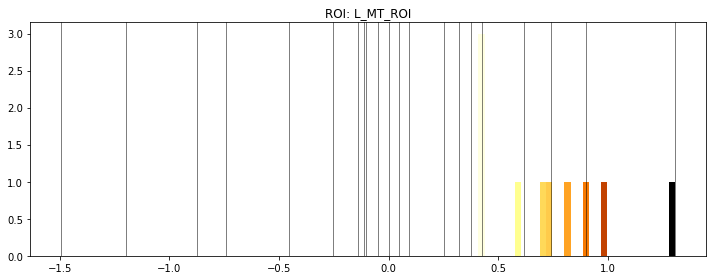

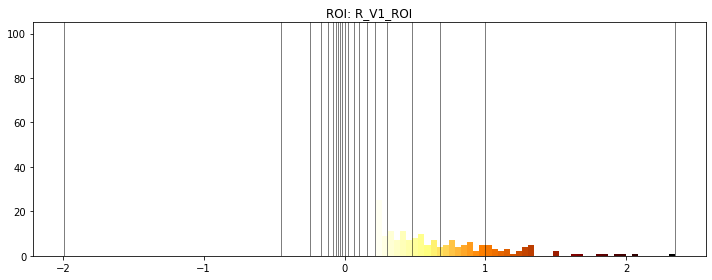

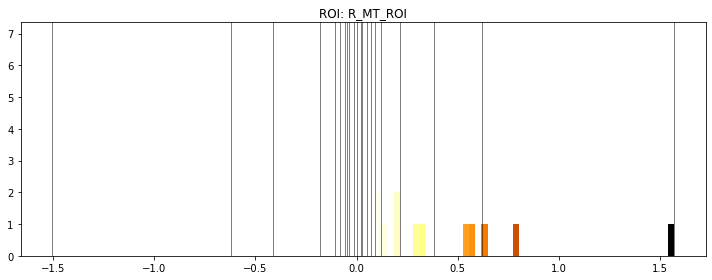

In [16]:
pc_comp = 0
n_bins = 100
PRC_ROI_CSD = {}
COLOR_MAP_ROI = {}
SC_LOG_ROI = {}
for l in ROI_labels:
    prc = np.linspace(0, 100, num=21)
    prc_bounds = list(zip(prc[:-1], prc[1:]))
    csd_bounds = []
    sc_log = np.log10(np.abs(PCA_results[l][0][:, pc_comp]))
    sc_log = sc_log - np.median(sc_log)
    SC_LOG_ROI[l] = sc_log
    PRC_ROI_CSD[l] = csd_bounds
    COLOR_MAP_ROI[l] = data_to_rgb(
        sc_log, n_bins, "afmhot_r", np.percentile(sc_log, 75), 
        np.percentile(sc_log, 100), vcenter=np.percentile(sc_log, 95)
    )


for l in ROI_labels:
#     ~ROI_outlier_map[l]
#     COLOR_MAP_ROI[l]
    sc_log = SC_LOG_ROI[l]
    f, ax = plt.subplots(1, 1, figsize=(10, 4))
    datacolors, mappable = data_to_rgb(
        sc_log, n_bins, "afmhot_r", np.percentile(sc_log, 75), 
        np.percentile(sc_log, 100), vcenter=np.percentile(sc_log, 95), ret_map=True
    )
    hist, bins, barlist = ax.hist(sc_log, bins=n_bins)
    for ix, xx in enumerate(barlist):
        plt.setp(xx, "facecolor", mappable.to_rgba(bins[ix+1]))

    for h in np.linspace(0, 100, num=21):
        ax.axvline(np.percentile(sc_log, h), lw=0.5, c="black")
    ax.set_title("ROI: {}".format(l))
    plt.tight_layout()
    plt.savefig("/home/mszul/git/DANC_multilayer_laminar/output/PC_{}_{}_brain_colormap.png".format(str(pc_comp+1).zfill(2), l), dpi=300)
    
    data_colour_map = np.repeat(np.array([[0, 1, 0.224]]), ROI_vertices[l].shape[0], axis=0)
    data_colour_map[~ROI_outlier_map[l]] = COLOR_MAP_ROI[l][:,:3]
    gray = np.array([0.5, 0.5, 0.5])
    brain = nb.load(info["pial_ds_nodeep_inflated"])
    vertices, faces = brain.agg_data()
    colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
    for ix, v in enumerate(ROI_vertices[l]):
        colours[v] = data_colour_map[ix][:3]
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
    mesh = mesh.as_open3d
    mesh.compute_vertex_normals(normalized=True)
    mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
    vxmask = np.array([i.decode("utf=8")[0] != l[0] for i in atlas_labels]) | np.array([i.decode("utf=8")[0] == "?" for i in atlas_labels])
    mesh.remove_vertices_by_mask(vxmask)
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)
    

In [270]:
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, v in enumerate(ROI_vertices[l]):
    colours[v] = data_colour_map[ix][:3]

In [26]:
gray = np.array([0.5, 0.5, 0.5])
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, v in enumerate(ROI_vertices["R_V1_ROI"][np.argsort(SC_LOG_ROI["R_V1_ROI"])[-2:]]):
    colours[v] = np.array([0, 1, 0.224])
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
vxmask = np.array([i.decode("utf=8")[0] != l[0] for i in atlas_labels]) | np.array([i.decode("utf=8")[0] == "?" for i in atlas_labels])
mesh.remove_vertices_by_mask(vxmask)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)